# Introduction
Bellabeat is a successful small company founded in 2013 with the purpose of providing high tech health-focused products for women. The company’s main products are the **“Leaf”**, **“Time”**, and **“Spring”**. All three products are smart devices that collects and syncs data with the Bellabeat app. Bellabeat also provides a subscription-based membership program that provides guidance on nutrition, activity, sleep, health and beauty. Bellabeat has the potential to be a powerhouse in the smart device market and they believe that analyzing smart device data can provide valuable insight on how they can grow.

## Business Task Statement
Our goal is to use consumer data to make informed decisions on how to improve marketing strategies for one of Bellabeat’s products.

In order to address the business task, we will consider the following:

1. What are some trends in smart device usage
2. How could these trends apply to Bellabeat customers?
3. How could these trends help influence Bellabeat marketing strategy?

## Stakeholders
* **Urška Sršen:** Bellabeat’s cofounder and Chief Creative Officer
* **Sando Mur:** Mathematician and Bellabeat’s co-founder; key member of the Bellabeat executive team

# Preparing the Data

We will be getting our data from [FitBit Fitness Tracker Data](https://www.kaggle.com/datasets/arashnic/fitbit). 

Some information regarding the dataset:
* The dataset is from a Public Domain. 
* The dataset is from 2016.
* The dataset was collected from 30 Fitbit users who consented to having their personal tracker information submitted. 

We will need to load the necessary package and import the CSV files from the FitBit Fitness Tracker.
There are 18 .csv files. Many of the files contain overlapping data. We will be using the following 4 .csv files for our analysis.
* dailyActivity_merged.csv
* hourlyIntensities_merged.csv
* sleepDay_merged.csv
* weightLogInfo_merged.csv

In [ ]:
#loading packages
library(tidyverse)
library(dplyr)

In [ ]:
#importing the necessary .csv files for analysis.
dailyActivity <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")
hourlyIntensities <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv")
sleep <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
weight <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

Now that we have our datasets, we want to quickly preview them to see if everything is correct. We are going to use head(), col(), and View(). 

Here are some things that I noticed while previewing the data:
* Gender is not included in any of the datasets.
* Dates are categorized as strings.
* Some date-time data are categorized as strings.
* Fat information is missing from multiple users in the 'Fat' column for the 'weight' table.
* IsManualReport column is categorized as strings even though it should be boolean.


In [ ]:
# Here are 2 data frame previews in which you can see the wrong data type for certain columns.
head(dailyActivity)
head(weight)

# Processing/Cleaning the Data

## Cleaning

We start by changing the data types of date related columns to 'date' and the IsManualReport column in weight to 'logical'. We are also changing the column name of dates to 'Date' for all the data frames.

In [ ]:
#dailyActivity
dailyActivity$ActivityDate = as.POSIXct(dailyActivity$ActivityDate,"%m/%d/%Y", tz=Sys.timezone())
dailyActivity$Date <- as.Date(dailyActivity$ActivityDate) #creating a column named 'Date' for merge later

#hourlyIntensities
hourlyIntensities$ActivityHour=as.POSIXct(hourlyIntensities$ActivityHour, format="%m/%d/%Y %I:%M:%S %p", tz=Sys.timezone())
hourlyIntensities$time <- format(hourlyIntensities$ActivityHour, format = "%H:%M:%S")
hourlyIntensities$date <- format(hourlyIntensities$ActivityHour, format = "%m/%d/%y")

#sleep
sleep$SleepDay = as.POSIXct(sleep$SleepDay, "%m/%d/%Y", tz=Sys.timezone())
sleep$Date <- as.Date(sleep$SleepDay)

#weight
weight$Date = as.POSIXct(weight$Date,"%m/%d/%Y", tz=Sys.timezone())
weight$Date <- as.Date(weight$Date)
weight$IsManualReport <- as.logical(weight$IsManualReport)

I also noticed that user IDs gets repeated in many of these data tables. I want to find out how many distinct users are in each data set.

In [ ]:
n_distinct(dailyActivity$Id)
n_distinct(hourlyIntensities$Id)
n_distinct(sleep$Id)
n_distinct(weight$Id)

This is inconsistent with the information given. We were expecting 30 distinct users but we have 33 unique Ids.

sleepDay and weightLogInfo is missing 6 and 22 users respectively. This may affect the result of the analysis.

We will not look at weight in our analysis since 8 users is not enough datapoints to make a conclusion.

# Analyzing the Data

## Summary Statistics

We will first take a look some summary statistics to see if we can make meaningful insights.

In [ ]:
#Total steps, total distance, and ssedentary minutes from 'dailyActivity'
dailyActivity %>%  
  select(TotalSteps,
         TotalDistance,
         SedentaryMinutes, Calories) %>%
  summary()

#Minutes spent sleeping and minutes spent in bed from 'sleep'
sleep %>%
    select(TotalMinutesAsleep,
          TotalTimeInBed) %>%
    summary()

#Weight in pounds and BMI from 'weight'
weight %>%
    select(WeightPounds,
          BMI) %>%
    summary()

## Insights
* Average amount of steps per day is 7638. Which can be set as a daily goal for users.
* Average sedentary minutes is 991.2 minutes, which is 16.52 hours. Users may need to be more active to burn more calories.
* Average calories burned is 2304. According to the Dietary Guidelines for Americans 2020–2025, the average adult woman expends roughly 1,600 to 2,400 calories per day, while the average adult man expends 2,000 to 3,000.
* Average time spend asleep is 419.5 minutes, which is approximately 7 hours. This meets the CDC's minimum recommended hours of sleep per day.
* Average BMI is 25.19, which is categorized as 'overweight' according to CDC.

## Hypothesis
Here are some hypothesis that we are going to look at:
* There is a relationship between activity levels and calories burned
* There is a relationship between number of steps and calories burned
* There is a relationship between sedentary minutes and sleep time
* There is a preferential time during the day where users are more active

## Aggravating Data
We are going to merge data before we create visualizations to test our hypothesis. 

We are also going to preview the data with head() and n_distinct to make sure the merge was done correctly.



In [ ]:
merged_data <- full_join(sleep, dailyActivity, by=c('Id', 'Date'))
head(merged_data)
n_distinct(merged_data$Id)

We noticed that there are no data for total activity minutes, so we will make the column for that.

In [ ]:
merged_data$TotalActiveMinutes = (merged_data$VeryActiveMinutes + merged_data$FairlyActiveMinutes + merged_data$LightlyActiveMinutes)
head(merged_data)

# Visualizations

In [ ]:
# Total Activity Minutes vs. Calories
ggplot(data=merged_data, aes(x=TotalActiveMinutes, y=Calories)) + 
  geom_point(size = 1) + geom_smooth(method = 'lm', formula = y~x, color = 'red', linewidth = 2) + labs(title="Total Activity Minutes vs. Calories") + theme(plot.title = element_text(size=25) , axis.title.x = element_text(size=15), axis.title.y = element_text(size=17), axis.text = element_text(size=12))

# Total Steps vs. Calories
ggplot(data=merged_data, aes(x=TotalSteps, y=Calories)) + 
  geom_point(size = 1) + geom_smooth(method = 'lm', formula = y~x, color = 'red', linewidth = 2) + labs(title="Numbers of Steps vs. Calories") + theme(plot.title = element_text(size=25) , axis.title.x = element_text(size=15), axis.title.y = element_text(size=17), axis.text = element_text(size=12))

Based on the data analysis, we have identified a significant positive correlation between the number of active minutes and calories burned, as well as a positive correlation between the number of steps and calories burned. Notably, the correlation between the number of steps and calories burned appears to be stronger.

Taking this information into consideration, Bellabeat can leverage these findings to recommend daily step goals to our users and celebrate their achievements upon reaching their step targets. This personalized approach will encourage users to stay active and promote a healthier lifestyle.

Furthermore, we will analyze the breakdown of total activity minutes into light, moderate, and vigorous intensity levels and examine their relationship with calories burned. Additionally, we will incorporate sedentary minutes into our analysis. We will do this by utilizing Tableau.

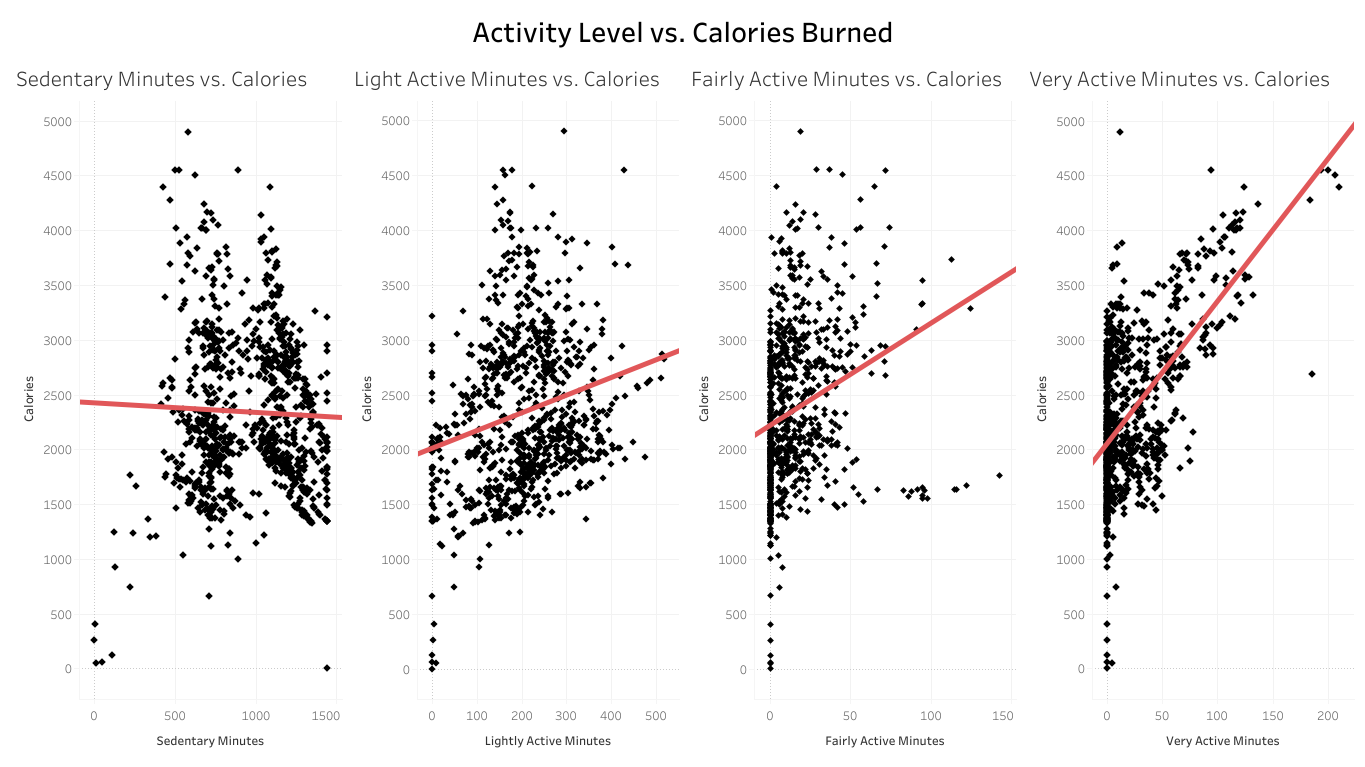

Based on our visualization, we have observed that increased activity leads to higher calorie expenditure. Additionally, we have identified a negative correlation between sedentary minutes and calorie burn. This implies that as users remain inactive for longer durations, their calorie expenditure decreases progressively.

Leveraging this valuable insight, **Bellabeat can utilize the data to send notifications to users who have been inactive for extended periods.**

Moving forward, we will examine the hourly intensities spreadsheet to uncover any patterns or trends regarding peak activity levels. This analysis will provide us with valuable information about the specific times when individuals tend to be most active. 

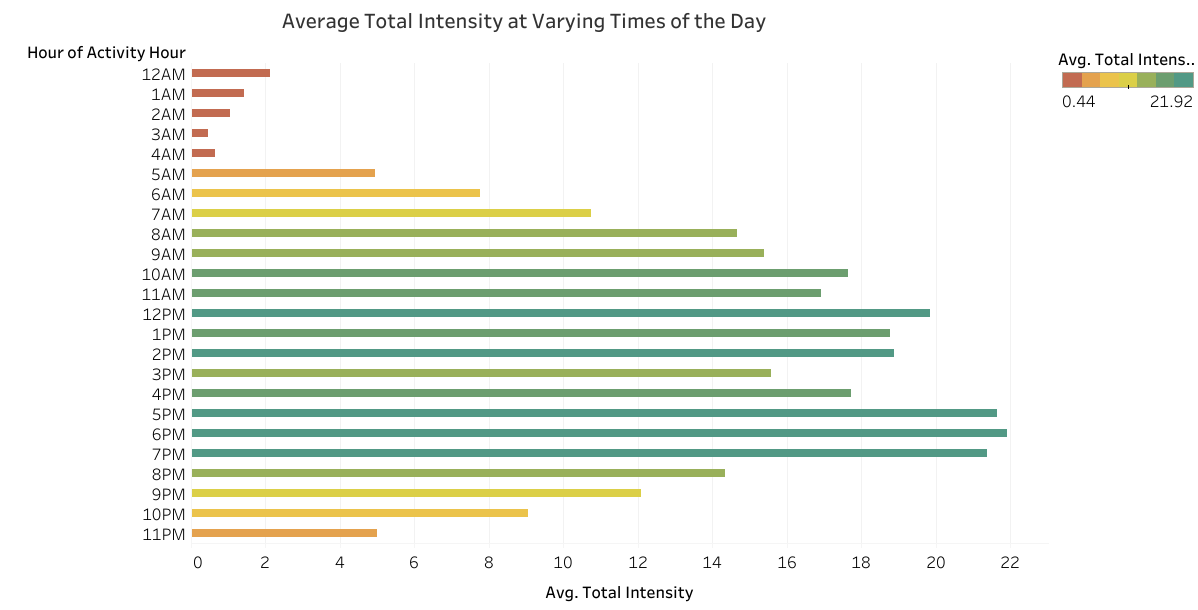

Here, we can observe that the period between 5 PM and 7 PM exhibits the highest intensity of physical activity. This suggests that Fitbit users may have a preferred timeframe for their workout sessions. Using this information, **we can encourage users to prepare for physical activity just before 5 PM**

Lastly, our analysis will focus on examining the connection between sedentary minutes and sleep duration. By exploring this relationship, we aim to gain insights into how periods of sedentary behavior may impact the quality and duration of sleep.

In [ ]:
# Sedentary Minutes vs. Sleep Time
ggplot(data=merged_data, aes(x=SedentaryMinutes, y=TotalMinutesAsleep)) + 
  geom_point(size = 1) + geom_smooth(method = 'lm', formula = y~x, color = 'red', linewidth = 2) + labs(title="Sedentary Minutes vs. Sleep Time") + theme(plot.title = element_text(size=25) , axis.title.x = element_text(size=15), axis.title.y = element_text(size=17), axis.text = element_text(size=12))


There is a negative correlation between sedentary minutes and total time spent asleep. **If users are not getting enough sleep, we can recommend users to reduce sedentary time**

# Conclusion and Recommendations

## Conclusion
From the analysis, we observed the following:

* Higher activity (intensity and duration) correlates positively with calories burned.
* Amount of sleep negatively correlates with inactive time.
* Peak user activity occurs between 5PM and 7PM.

## Recommendations

### Bellabeat App
* Set daily step goals (7500 - 10000) and offer incentives for goal achievement.
* Send reminders to exercise at 5PM for inactive users.
* Allow users to input health goals and customize notifications.

### Bellabeat Leaf / Time
* Enhance sleep tracking technology to suggest movement for users with insufficient sleep and to reduce sedentary time.

### Bellabeat Membership
* Offer free trials to showcase product benefits and increase subscription likelihood.
* Implement incentives or reward systems for users.

### Advertising
* Target advertisements during the 4PM - 8PM slot when fitness is on top of people's mind.